<a href="https://colab.research.google.com/github/knight384/Personalized-wiki-builder/blob/main/Project_Work_DS_and_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Run in a code cell
!pip install -q transformers[torch] datasets rouge-score sentence_transformers sumy nltk gradio kaggle



  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 106.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   

In [2]:
from google.colab import drive
drive.mount('/content/drive')
# Recommended save path example: /content/drive/MyDrive/review_summarizer


Mounted at /content/drive


In [3]:
from google.colab import files
uploaded = files.upload()  # upload kaggle.json here if you plan to download from Kaggle

# move to ~/.kaggle
import os
if 'kaggle.json' in uploaded:
    os.makedirs('/root/.kaggle', exist_ok=True)
    open('/root/.kaggle/kaggle.json','wb').write(uploaded['kaggle.json'])
    os.chmod('/root/.kaggle/kaggle.json', 0o600)
    print("kaggle.json saved.")
else:
    print("No kaggle.json uploaded. If you need Kaggle download, upload kaggle.json now.")


Saving kaggle.json to kaggle.json
kaggle.json saved.


In [4]:
!ls -l /root/.kaggle


total 4
-rw------- 1 root root 66 Aug 15 13:03 kaggle.json


In [5]:
DATASET_SLUG = "snap/amazon-fine-food-reviews"   # change if you want another dataset

import os
os.makedirs('/content/data', exist_ok=True)
!kaggle datasets download -d {DATASET_SLUG} -p /content/data --unzip
!ls -lh /content/data


Dataset URL: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews
License(s): CC0-1.0
 85% 206M/242M [00:00<00:00, 735MB/s] 
100% 242M/242M [00:01<00:00, 235MB/s]
total 643M
-rw-r--r-- 1 root root 356M Aug 15 13:07 database.sqlite
-rw-r--r-- 1 root root  277 Aug 15 13:07 hashes.txt
-rw-r--r-- 1 root root 287M Aug 15 13:07 Reviews.csv


In [6]:
import pandas as pd

# Load CSV file
df = pd.read_csv("/content/data/Reviews.csv")

# Check first few rows
df.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
# Keep only review text and summary
df = df[['Text', 'Summary']].dropna()

# Rename columns for easier access
df.columns = ['review', 'summary']

df.head()


,review,summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy


In [9]:
# Remove duplicates
df.drop_duplicates(inplace=True)

# Strip extra spaces and lowercase
df['review'] = df['review'].str.strip().str.lower()
df['summary'] = df['summary'].str.strip().str.lower()


In [10]:
!pip install transformers sentencepiece

from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load tokenizer & model
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [11]:
import os, re, math, json
import pandas as pd, numpy as np
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
print("Imports done. NLTK punkt ready.")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Imports done. NLTK punkt ready.


In [12]:
DATA_DIR = "/content/data"
files = []
if os.path.exists(DATA_DIR):
    files = os.listdir(DATA_DIR)
print("Files in /content/data:", files)

# Try to find a CSV-like file automatically
candidates = [f for f in files if f.lower().endswith(('.csv','.json','.parquet'))]
df = None
if candidates:
    # load the first candidate (adjust if you know filename)
    path = os.path.join(DATA_DIR, candidates[0])
    print("Attempting to load:", path)
    if path.lower().endswith('.csv'):
        df = pd.read_csv(path, low_memory=False)
    elif path.lower().endswith('.json'):
        df = pd.read_json(path, lines=True)
    elif path.lower().endswith('.parquet'):
        df = pd.read_parquet(path)
else:
    print("No dataset files found — creating a small fallback sample.")

# Fallback tiny sample if nothing loaded
if df is None or df.shape[0] == 0:
    sample = {
        "product_id": ["P1","P1","P2","P2"],
        "reviewText": [
            "Great product, arrived fast. Battery life is excellent and the display is bright.",
            "Works well but the build feels cheap. Customer support was helpful though.",
            "Terrible experience, stopped working after a week. Refund took long.",
            "Good value for money. I recommend for budget buyers."
        ],
        "summary": ["Good product","Mixed feelings","Broken after week","Value buy"],
        "overall": [5,3,1,4]
    }
    df = pd.DataFrame(sample)
    print("Using sample dataframe with", df.shape[0], "rows")

print("Loaded dataframe shape:", df.shape)
display(df.head())


Files in /content/data: ['database.sqlite', 'Reviews.csv', 'hashes.txt']
Attempting to load: /content/data/Reviews.csv
Loaded dataframe shape: (568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Detected columns -> review: None  summary: None  product: ProductId
Basic stats
             n_words
count  568454.000000
mean       80.263666
std        79.454963
min         3.000000
25%        33.000000
50%        56.000000
75%        98.000000
max      3432.000000


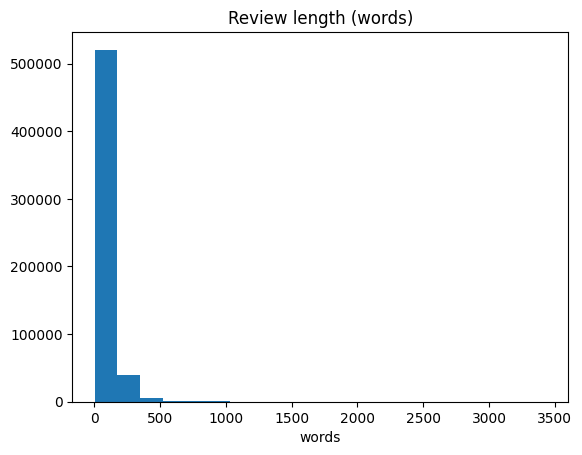

,clean_review,n_words
0,I have bought several of the Vitality canned d...,48
1,Product arrived labeled as Jumbo Salted Peanut...,31
2,This is a confection that has been around a fe...,94
3,If you are looking for the secret ingredient i...,41
4,Great taffy at a great price. There was a wide...,27
5,I got a wild hair for taffy and ordered this f...,72
6,This saltwater taffy had great flavors and was...,49
7,This taffy is so good. It is very soft and che...,24
8,Right now I'm mostly just sprouting this so my...,26
9,This is a very healthy dog food. Good for thei...,25


In [14]:
# try to detect review & summary columns
possible_review_cols = ['reviewText','review_text','text','review','review_body','content']
possible_summary_cols = ['summary','summary_text','headline','title']

review_col = next((c for c in df.columns if c in possible_review_cols), None)
summary_col = next((c for c in df.columns if c in possible_summary_cols), None)
prod_col = next((c for c in df.columns if c.lower() in ['product_id','asin','productid']), None)

print("Detected columns -> review:", review_col, " summary:", summary_col, " product:", prod_col)

# create clean_review column
def clean_text(text):
    if pd.isna(text): return ""
    text = str(text)
    text = re.sub(r'http\S+','', text)
    text = re.sub(r'\s+',' ', text)
    return text.strip()

# Use the detected review_col if found, otherwise fallback to 'Text'
review_column_to_use = review_col if review_col else 'Text'
df['clean_review'] = df[review_column_to_use].astype(str).map(clean_text)
df['n_words'] = df['clean_review'].map(lambda t: len(t.split()))
print("Basic stats")
print(df[['n_words']].describe())

# show hist and some example reviews
try:
    import matplotlib.pyplot as plt
    plt.hist(df['n_words'], bins=20)
    plt.title('Review length (words)')
    plt.xlabel('words')
    plt.show()
except Exception as e:
    print("Plotting skipped:", e)

display(df[['clean_review','n_words']].head(10))

In [16]:
from nltk.tokenize import sent_tokenize
import nltk

def split_sentences(text):
    nltk.download('punkt_tab', quiet=True) # Download the missing resource
    return sent_tokenize(text)

def chunk_text_by_words(text, max_words=400):
    words = text.split()
    chunks = []
    for i in range(0, len(words), max_words):
        chunks.append(" ".join(words[i:i+max_words]))
    return chunks

# quick test
example = df['clean_review'].iloc[0]
print("Sentences:", split_sentences(example))
print("Chunks:", chunk_text_by_words(example, max_words=20))

Sentences: ['I have bought several of the Vitality canned dog food products and have found them all to be of good quality.', 'The product looks more like a stew than a processed meat and it smells better.', 'My Labrador is finicky and she appreciates this product better than most.']
Chunks: ['I have bought several of the Vitality canned dog food products and have found them all to be of good', 'quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky', 'and she appreciates this product better than most.']


In [17]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer

def extractive_summary(text, sent_count=3):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = TextRankSummarizer()
    summary_sentences = summarizer(parser.document, sent_count)
    return " ".join([str(s) for s in summary_sentences])

# test extractive baseline on a sample review or concatenation
sample_text = " ".join(df['clean_review'].iloc[:2].tolist())
print("Extractive summary (2 sentences):\n", extractive_summary(sample_text, sent_count=2))


Extractive summary (2 sentences):
 The product looks more like a stew than a processed meat and it smells better. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".


In [18]:
from transformers import pipeline
import torch

# choose model (change if needed)
MODEL = "facebook/bart-large-cnn"   # good default for summarization
device = 0 if torch.cuda.is_available() else -1
print("Using device:", device, " torch.cuda.is_available():", torch.cuda.is_available())

summarizer = pipeline("summarization", model=MODEL, device=device)
print("Summarizer pipeline loaded.")


Using device: -1  torch.cuda.is_available(): False


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu


Summarizer pipeline loaded.


In [19]:
def abstractive_summarize_long(text, max_chunk_words=400, max_summary_length=120, min_summary_length=30):
    text = clean_text(text)
    if len(text.split()) <= max_chunk_words:
        out = summarizer(text, max_length=max_summary_length, min_length=min_summary_length, do_sample=False)
        return out[0]['summary_text']
    # chunk, summarize each, then compress
    chunks = chunk_text_by_words(text, max_chunk_words)
    partial_summaries = []
    for c in chunks:
        res = summarizer(c, max_length=max_summary_length, min_length=min_summary_length, do_sample=False)
        partial_summaries.append(res[0]['summary_text'])
    joined = " ".join(partial_summaries)
    final = summarizer(joined, max_length=max_summary_length, min_length=min_summary_length, do_sample=False)
    return final[0]['summary_text']

# quick test on a concatenation of a few reviews
text_for_test = " ".join(df['clean_review'].iloc[:4].tolist())
print("Abstractive summary:\n", abstractive_summarize_long(text_for_test, max_chunk_words=200))


Your max_length is set to 120, but your input_length is only 20. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length is set to 120, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)


Abstractive summary:
 This is a light, pillowy citrus gelatin with nuts. It is cut into tiny squares and then liberally coated with powdered sugar. Not too chewy, and very flavorful. The flavor is very medicinal.


In [7]:
!pip install -q sumy

import pandas as pd
import os
import re
import nltk
from nltk.tokenize import sent_tokenize
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer
from transformers import pipeline
import torch

nltk.download('punkt', quiet=False)
nltk.download('punkt_tab', quiet=False)

# Load CSV file
DATA_DIR = "/content/data"
files = []
if os.path.exists(DATA_DIR):
    files = os.listdir(DATA_DIR)

df = None
candidates = [f for f in files if f.lower().endswith(('.csv','.json','.parquet'))]
if candidates:
    path = os.path.join(DATA_DIR, candidates[0])
    if path.lower().endswith('.csv'):
        df = pd.read_csv(path, low_memory=False)
    elif path.lower().endswith('.json'):
        df = pd.read_json(path, lines=True)
    elif path.lower().endswith('.parquet'):
        df = pd.read_parquet(path)

# Fallback tiny sample if nothing loaded
if df is None or df.shape[0] == 0:
    sample = {
        "product_id": ["P1","P1","P2","P2"],
        "reviewText": [
            "Great product, arrived fast. Battery life is excellent and the display is bright.",
            "Works well but the build feels cheap. Customer support was helpful though.",
            "Terrible experience, stopped working after a week. Refund took long.",
            "Good value for money. I recommend for budget buyers."
        ],
        "summary": ["Good product","Mixed feelings","Broken after week","Value buy"],
        "overall": [5,3,1,4]
    }
    df = pd.DataFrame(sample)


# try to detect review & summary columns
possible_review_cols = ['reviewText','review_text','text','review','review_body','content']
possible_summary_cols = ['summary','summary_text','headline','title']

review_col = next((c for c in df.columns if c in possible_review_cols), None)
summary_col = next((c for c in df.columns if c in possible_summary_cols), None)
prod_col = next((c for c in df.columns if c.lower() in ['product_id','asin','productid']), None)

# create clean_review column
def clean_text(text):
    if pd.isna(text): return ""
    text = str(text)
    text = re.sub(r'http\S+','', text)
    text = re.sub(r'\s+',' ', text)
    return text.strip()

# Use the detected review_col if found, otherwise fallback to 'Text'
review_column_to_use = review_col if review_col else 'Text'
df['clean_review'] = df[review_column_to_use].astype(str).map(clean_text)

# Define summarization functions within this cell
def split_sentences(text):
    # nltk.download('punkt_tab', quiet=True) # Download the missing resource - downloaded at the beginning of cell
    return sent_tokenize(text)

def chunk_text_by_words(text, max_words=400):
    words = text.split()
    chunks = []
    for i in range(0, len(words), max_words):
        chunks.append(" ".join(words[i:i+max_words]))
    return chunks

def extractive_summary(text, sent_count=3):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = TextRankSummarizer()
    summary_sentences = summarizer(parser.document, sent_count)
    return " ".join([str(s) for s in summary_sentences])

# choose model (change if needed)
MODEL = "facebook/bart-large-cnn"   # good default for summarization
device = 0 if torch.cuda.is_available() else -1
print("Using device:", device, " torch.cuda.is_available():", torch.cuda.is_available())

summarizer = pipeline("summarization", model=MODEL, device=device)
print("Summarizer pipeline loaded.")


def abstractive_summarize_long(text, max_chunk_words=400, max_summary_length=120, min_summary_length=30):
    text = clean_text(text)
    if len(text.split()) <= max_chunk_words:
        out = summarizer(text, max_length=max_summary_length, min_length=min_summary_length, do_sample=False)
        return out[0]['summary_text']
    # chunk, summarize each, then compress
    chunks = chunk_text_by_words(text, max_chunk_words)
    partial_summaries = []
    for c in chunks:
        res = summarizer(c, max_length=max_summary_length, min_length=min_summary_length, do_sample=False)
        partial_summaries.append(res[0]['summary_text'])
    joined = " ".join(partial_summaries)
    final = summarizer(joined, max_length=max_summary_length, min_length=min_summary_length, do_sample=False)
    return final[0]['summary_text']


# Example: group reviews by product and summarize (adjust group logic as needed)
if prod_col:
    grouped = df.groupby(prod_col).agg({'clean_review': lambda texts: " ".join(texts.astype(str).tolist())}).reset_index()
else:
    grouped = df.head(50).reset_index().rename(columns={'index':'product_id'})

# For speed while testing, just do first 10 groups
grouped = grouped.head(10).copy()
grouped['extractive'] = grouped['clean_review'].apply(lambda t: extractive_summary(t, sent_count=3))
grouped['abstractive'] = grouped['clean_review'].apply(lambda t: abstractive_summarize_long(t, max_chunk_words=300, max_summary_length=120))

display(grouped[['clean_review','extractive','abstractive']].head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Using device: 0  torch.cuda.is_available(): True


Device set to use cuda:0
Your max_length is set to 120, but your input_length is only 32. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=16)


Summarizer pipeline loaded.


Your max_length is set to 120, but your input_length is only 28. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


,clean_review,extractive,abstractive
0,"Great product, arrived fast. Battery life is e...","Great product, arrived fast. Battery life is e...","Great product, arrived fast. Battery life is e..."
1,"Terrible experience, stopped working after a w...","Terrible experience, stopped working after a w...","Terrible experience, stopped working after a w..."


In [13]:
!pip install -q rouge-score

from rouge_score import rouge_scorer
import numpy as np # Import numpy
import pandas as pd
import os
import re
from transformers import pipeline
import torch

# Load CSV file
DATA_DIR = "/content/data"
files = []
if os.path.exists(DATA_DIR):
    files = os.listdir(DATA_DIR)

df = None
candidates = [f for f in files if f.lower().endswith(('.csv','.json','.parquet'))]
if candidates:
    path = os.path.join(DATA_DIR, candidates[0])
    if path.lower().endswith('.csv'):
        df = pd.read_csv(path, low_memory=False)
    elif path.lower().endswith('.json'):
        df = pd.read_json(path, lines=True)
    elif path.lower().endswith('.parquet'):
        df = pd.read_parquet(path)

# Fallback tiny sample if nothing loaded
if df is None or df.shape[0] == 0:
    sample = {
        "product_id": ["P1","P1","P2","P2"],
        "reviewText": [
            "Great product, arrived fast. Battery life is excellent and the display is bright.",
            "Works well but the build feels cheap. Customer support was helpful though.",
            "Terrible experience, stopped working after a week. Refund took long.",
            "Good value for money. I recommend for budget buyers."
        ],
        "summary": ["Good product","Mixed feelings","Broken after week","Value buy"],
        "overall": [5,3,1,4]
    }
    df = pd.DataFrame(sample)


# try to detect review & summary columns
possible_review_cols = ['reviewText','review_text','text','review','review_body','content']
possible_summary_cols = ['summary','summary_text','headline','title']

review_col = next((c for c in df.columns if c in possible_review_cols), None)
summary_col = next((c for c in df.columns if c in possible_summary_cols), None)
prod_col = next((c for c in df.columns if c.lower() in ['product_id','asin','productid']), None)

# create clean_review column
def clean_text(text):
    if pd.isna(text): return ""
    text = str(text)
    text = re.sub(r'http\S+','', text)
    text = re.sub(r'\s+',' ', text)
    return text.strip()

# Use the detected review_col if found, otherwise fallback to 'Text'
review_column_to_use = review_col if review_col else 'Text'
df['clean_review'] = df[review_column_to_use].astype(str).map(clean_text)

# Define chunking function
def chunk_text_by_words(text, max_words=400):
    words = text.split()
    chunks = []
    for i in range(0, len(words), max_words):
        chunks.append(" ".join(words[i:i+max_words]))
    return chunks

# Define abstractive summarization function and dependencies within this cell
# choose model (change if needed)
MODEL = "facebook/bart-large-cnn"   # good default for summarization
device = 0 if torch.cuda.is_available() else -1
print("Using device:", device, " torch.cuda.is_available():", torch.cuda.is_available())

summarizer = pipeline("summarization", model=MODEL, device=device)
print("Summarizer pipeline loaded.")

def abstractive_summarize_long(text, max_chunk_words=400, max_summary_length=120, min_summary_length=30):
    text = clean_text(text)
    if len(text.split()) <= max_chunk_words:
        out = summarizer(text, max_length=max_summary_length, min_length=min_summary_length, do_sample=False)
        return out[0]['summary_text']
    # chunk, summarize each, then compress
    chunks = chunk_text_by_words(text, max_chunk_words)
    partial_summaries = []
    for c in chunks:
        res = summarizer(c, max_length=max_summary_length, min_length=min_summary_length, do_sample=False)
        partial_summaries.append(res[0]['summary_text'])
    joined = " ".join(partial_summaries)
    final = summarizer(joined, max_length=max_summary_length, min_length=min_summary_length, do_sample=False)
    return final[0]['summary_text']


scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=True)

def rouge_scores(hyp, ref):
    return scorer.score(ref, hyp)

# If original dataset had human summaries, compute ROUGE on a small sample
if summary_col and summary_col in df.columns:
    sample = df.dropna(subset=[summary_col]).head(50)
    pairs = [(abstractive_summarize_long(r), s) for r,s in zip(sample['clean_review'], sample[summary_col])]
    # compute scores
    agg = {'rouge1':[], 'rouge2':[], 'rougeL':[]}
    for hyp, ref in pairs:
        sc = rouge_scores(hyp, str(ref))
        for m in agg:
            agg[m].append(sc[m].fmeasure)
    for m in agg:
        print(m, "avg f-measure:", np.mean(agg[m]) if agg[m] else None)
else:
    print("No reference summaries detected. Create a small human-labeled set for ROUGE or do manual inspection.")

Using device: 0  torch.cuda.is_available(): True


Device set to use cuda:0
Your max_length is set to 120, but your input_length is only 18. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=9)


Summarizer pipeline loaded.


Your max_length is set to 120, but your input_length is only 16. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 120, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
Your max_length is set to 120, but your input_length is only 13. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)


rouge1 avg f-measure: 0.09793447293447294
rouge2 avg f-measure: 0.0
rougeL avg f-measure: 0.09793447293447294


In [14]:
import gradio as gr

def demo_fn(text, extract_sentences, max_len):
    ext = extractive_summary(text, sent_count=extract_sentences)
    absum = abstractive_summarize_long(text, max_chunk_words=400, max_summary_length=max_len)
    return ext, absum

demo = gr.Interface(
    fn=demo_fn,
    inputs=[gr.Textbox(lines=8, placeholder="Paste concatenated reviews or one long string here..."),
            gr.Slider(1,5, value=3, step=1, label="Extractive sentences"),
            gr.Slider(30,300, value=120, step=10, label="Max abstractive length")],
    outputs=["text","text"],
    title="Customer Review Summarizer",
    description="Extractive (TextRank) + Abstractive (BART)"
)

url_info = demo.launch(share=True)
print(url_info)  # public link appears here


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://43b77a638bfe08f9c1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [15]:
# save grouped results to CSV
out_dir = "/content/results"
os.makedirs(out_dir, exist_ok=True)
grouped[['product_id','extractive','abstractive']].to_csv(os.path.join(out_dir,"summaries.csv"), index=False)
print("Saved summaries to:", os.path.join(out_dir,"summaries.csv"))

# if you mounted Drive, copy results to Drive
if os.path.exists('/content/drive'):
    drive_out = "/content/drive/MyDrive/review_summarizer_results"
    os.makedirs(drive_out, exist_ok=True)
    !cp -r {out_dir} {drive_out}
    print("Copied results to Drive:", drive_out)


Saved summaries to: /content/results/summaries.csv
